# Comparing circuit and QAF explanations in MLPs

For a given MLP, we aim to compare explanations for its behaviour.
We compare circuits identified using activation patching, and mechanisms identified using SpArX QAFs.

1. Train an MLP on the COMPAS dataset.
2. Use SpArX to produce a QAF explaining the MLP.
3. Use activation patching to quantify the importance of each neuron in the MLP with respect to the output. (Sweep over all neurons in the hidden layers and measure effect on output using logit differences.)

Potential outcomes:

* SpArX circuits are formed by averaging weights of clustered neurons
* Activation patching scores are based on logit differences after ablation
* Weights and activation values are both measures of a neuron's importance

* Can we cluster neurons based on their logit differences (importance scores)? Does this correspond to SpArX?
* 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import numpy as np
import tensorflow as tf
import tf_keras as keras

2025-03-04 11:28:31.100858: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 11:28:31.104154: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 11:28:31.112990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741087711.127090  389997 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741087711.131437  389997 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 11:28:31.146449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from tf_keras.models import Sequential
from tf_keras.layers import Dense
from SpArX.sparx import FFNN, KMeansClusterer, GlobalMerger, BokehVisualizer

## Set up dataset and MLP

In [4]:
def summarise_charge(x):
    drugs = ['clonaz', 'heroin', 'cocaine', 'cannabi', 'drug', 'pyrrolidin', 'Methyl', 'MDMA', 'Ethylone',
              'Alprazolam', 'Oxycodone',
              'Methadone', 'Methamph', 'Bupren', 'Lorazepam', 'controlled', 'Amphtamine', 'contro', 'cont sub',
              'rapher', 'fluoro',
              'ydromor', 'methox', 'iazepa', 'XLR11', 'steroid', 'morphin', 'contr sub', 'enzylpiper', 'butanediol',
              'phentermine',
              'Fentanyl', 'Butylone', 'Hydrocodone', 'LSD', 'Amobarbital', 'Amphetamine', 'Codeine', 'Carisoprodol']
    drugs_selling = ['sel', 'del', 'traf', 'manuf']
    if sum([d.lower() in x.lower() for d in drugs]) > 0:
        if sum([h in x.lower() for h in drugs_selling]) > 0:
            x = 'Drug Traffic'
        else:
            x = 'Drug Possess'
    elif 'murd' in x.lower() or 'manslaughter' in x.lower():
        x = 'Murder'
    elif 'sex' in x.lower() or 'porn' in x.lower() or 'voy' in x.lower() or 'molest' in x.lower() or 'exhib' in x.lower():
        x = 'Sex Crime'
    elif 'assault' in x.lower() or 'carjacking' in x.lower():
        x = 'Assault'
    elif 'child' in x.lower() or 'domestic' in x.lower() or 'negle' in x.lower() or 'abuse' in x.lower():
        x = 'Family Crime'
    elif 'batt' in x.lower():
        x = 'Battery'
    elif 'burg' in x.lower() or 'theft' in x.lower() or 'robb' in x.lower() or 'stol' in x.lower():
        x = 'Theft'
    elif 'fraud' in x.lower() or 'forg' in x.lower() or 'laund' in x.lower() or 'countrfeit' in x.lower() or 'counter' in x.lower() or 'credit' in x.lower():
        x = 'Fraud'
    elif 'prost' in x.lower():
        x = 'Prostitution'
    elif 'trespa' in x.lower() or 'tresspa' in x.lower():
        x = 'Trespass'
    elif 'tamper' in x.lower() or 'fabricat' in x.lower():
        x = 'Tampering'
    elif 'firearm' in x.lower() or 'wep' in x.lower() or 'wea' in x.lower() or 'missil' in x.lower() or 'shoot' in x.lower():
        x = 'Firearm'
    elif 'alking' in x.lower():
        x = 'Stalking'
    elif 'dama' in x.lower():
        x = 'Damage'
    elif 'driv' in x.lower() or 'road' in x.lower() or 'speed' in x.lower() or 'dui' in x.lower() or 'd.u.i.' in x.lower():
        x = 'Driving'

    else:
        x = 'Other'

    return x

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# Load the COMPAS dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

# Select relevant features and target variable
df['age'] = df['age_cat']
df['charge_desc'] = df['c_charge_desc']
df['charge_degree'] = df['c_charge_degree']

features = ['sex', 'age', 'race', 'decile_score', 'out_custody', 'in_custody',
            'juv_fel_count', 'juv_misd_count', 'juv_other_count',
            'priors_count', 'days_b_screening_arrest', 'charge_degree', 'charge_desc',
            'is_recid', 'is_violent_recid', 'priors_count']
target = 'two_year_recid'

df = df[features + [target]]
# Drop rows with missing values
df = df.dropna()
df['charge_desc'] = df['charge_desc'].apply(summarise_charge)
df['custody'] = (df['out_custody'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - df['in_custody'].apply(
        lambda x: datetime.strptime(x, '%Y-%m-%d'))).apply(lambda x: x.total_seconds() / 3600 / 24).astype(int)
del df['out_custody']
del df['in_custody']

features.remove('out_custody')
features.remove('in_custody')
features.append('custody')

df.head()

sex              age              race  decile_score  juv_fel_count  \
0  Male  Greater than 45             Other             1              0   
1  Male          25 - 45  African-American             3              0   
2  Male     Less than 25  African-American             4              0   
5  Male          25 - 45             Other             1              0   
6  Male          25 - 45         Caucasian             6              0   

   juv_misd_count  juv_other_count  priors_count  days_b_screening_arrest  \
0               0                0             0                     -1.0   
1               0                0             0                     -1.0   
2               0                1             4                     -1.0   
5               0                0             0                      0.0   
6               0                0            14                     -1.0   

  charge_degree   charge_desc  is_recid  is_violent_recid  priors_count  \
0             F       Assault         0                 0             0   
1             F       Battery         1                 1             0   
2             F  Drug Possess         1                 0             4   
5             M       Battery         0                 0             0   
6             F         Theft         1                 0            14   

   two_year_recid  custody  
0               0        7  
1               1       10  
2               1        0  
5               0        1  
6               1       18

# Loading the trained model

In [6]:
# The model might have already been trained - in which case do not run the cells below this
from tf_keras.models import load_model

model = load_model('compas_model.keras')

W0000 00:00:1741087721.924351  389997 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Train the model

In [7]:
# Split the data into features and target
X = df[features]
y = df[target]

# One-hot
X = pd.get_dummies(X, drop_first=True)
y = pd.get_dummies(y, drop_first=True)

# Randomize
X = X.sample(frac=1, random_state=2020)
y = y.loc[X.index.values]
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(5520, 37) (1380, 37) (5520, 1) (1380, 1)


In [8]:
from tf_keras.metrics import Accuracy, Precision, Recall, F1Score

input_size = len(X.columns.values)
output_size = len(y.columns.values)

print(input_size)

# Build the model: one hidden layer with 200 hidden neurons
model = Sequential([
    Dense(200, activation='relu', input_shape=(input_size,)),
    Dense(output_size, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Accuracy(), Precision(), Recall(), F1Score()], run_eagerly=True)

# Print the model summary
model.summary()

37
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 7801 (30.47 KB)
Trainable params: 7801 (30.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# Convert y sets to float instead of bool
y_train = tf.convert_to_tensor(y_train, dtype=tf.float64)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float64)

print(X_train.dtype, y_train.dtype)
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

float64 <dtype: 'float64'>
Epoch 1/100
87/87 [==============================] - 2s 23ms/step - loss: 0.4168 - accuracy: 0.0000e+00 - precision_6: 0.8411 - recall_6: 0.8001 - f1_score: 0.6304 - val_loss: 0.2386 - val_accuracy: 0.0000e+00 - val_precision_6: 0.9384 - val_recall_6: 0.9786 - val_f1_score: 0.6431
Epoch 2/100
87/87 [==============================] - 2s 22ms/step - loss: 0.1786 - accuracy: 0.0000e+00 - precision_6: 0.9373 - recall_6: 0.9945 - f1_score: 0.6304 - val_loss: 0.1376 - val_accuracy: 0.0000e+00 - val_precision_6: 0.9424 - val_recall_6: 1.0000 - val_f1_score: 0.6431
Epoch 3/100
87/87 [==============================] - 2s 22ms/step - loss: 0.1282 - accuracy: 0.0000e+00 - precision_6: 0.9382 - recall_6: 0.9984 - f1_score: 0.6304 - val_loss: 0.1179 - val_accuracy: 0.0000e+00 - val_precision_6: 0.9451 - val_recall_6: 1.0000 - val_f1_score: 0.6431
Epoch 4/100
87/87 [==============================] - 2s 22ms/step - loss: 0.1164 - accuracy: 0.0000e+00 - precision_6: 0.9383 -

In [47]:
# Save the trained model
model.save("compas_model.keras")

44/44 [==============================] - 0s 11ms/step - loss: 0.1734 - accuracy: 0.0072 - precision_6: 0.9463 - recall_6: 0.9709 - f1_score: 0.7191


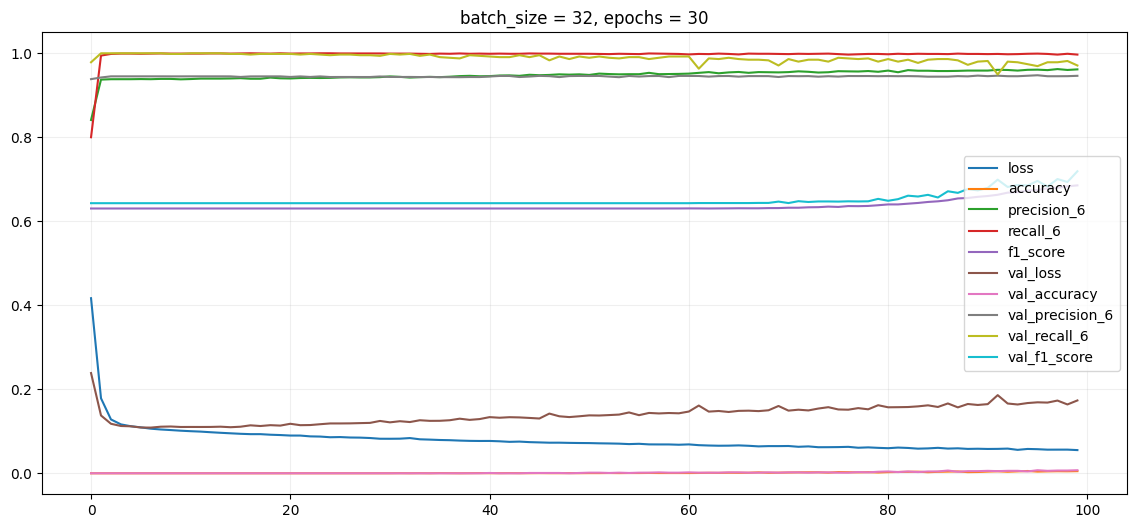

In [ ]:
score = model.evaluate(X_test, y_test)
plt.figure(figsize=(14, 6))
for key in history.history.keys():
    plt.plot(history.history[key], label=key)
plt.legend(loc='best')
plt.grid(alpha=.2)
plt.title(f'batch_size = 64, epochs = 100')
plt.draw()

# Question: same F1 score, but is accuracy meant to be so low?

# Perform SpArX

In [21]:
# shrink to a decimal percentage
SHRINK_TO_PERCENTAGE = 0.2

shape = (input_size, 200, output_size)
weights = [layer.get_weights()[0] for layer in model.layers]
bias = [layer.get_weights()[1] for layer in model.layers]
activations = ["relu", "relu", "sigmoid"]

restored_model = FFNN(shape, weights, bias, activations)

In [22]:
restored_model.forward_pass(X_train)


# cluster into 2 clusters
cluster_labels = KMeansClusterer.cluster(restored_model, SHRINK_TO_PERCENTAGE)

# merge clusters
merged_model = GlobalMerger.merge(restored_model, cluster_labels)
restored_model.model.summary()
merged_model.model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 200)               7600      
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 7801 (30.47 KB)
Trainable params: 7801 (30.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 40)                1520      
                                                                 
 dense_9 (Dense)             (None, 1)                 41        
                                                                

In [23]:
# Measure fidelity

def infidelity(x, y):
  return np.linalg.norm(x - y)/len(x)

restored_model.forward_pass(X_test)
original_output = restored_model.forward_pass_data[-1]

merged_model.forward_pass(X_test)
merged_output = merged_model.forward_pass_data[-1]

print(infidelity(original_output, merged_output))

0.008696976260862488


In [24]:
from bokeh.io import output_notebook
output_notebook()

BokehVisualizer.visualise(merged_model)

Loading BokehJS ...

In [17]:
from tf_keras import backend as K

def general_method_for_visualize_attack_and_supports_QBAF(input, output, model, feature_names, number_of_hidden_nodes,
                                                          quantile, weights, biases, path, fig_index):

    activation = compute_activations_for_each_layer(model, input)
    output_activation_in_correct_format = list(map(int, activation[-1][0] > 0.5))
    # import module
    from graphviz import Digraph
    import numpy as np
    import matplotlib.pyplot as plt

    # instantiating object
    dot = Digraph(comment='A Round Graph')
    dot.attr(rankdir="LR")
    dot.attr(splines='line')
    dot.subgraph()


    existing_nodes = []
    input = input.reshape(-1,)
    # Adding nodes
    for layer_index in range(len(number_of_hidden_nodes) + 2):  # +2 input and output layers
        if layer_index <= len(number_of_hidden_nodes):
          edge_weight_threshold = np.quantile(np.abs(np.array(weights[layer_index])).reshape(1, -1), quantile)
        existing_nodes.append([])
        if layer_index == 0:
            for i in range(len(input)):
                if input[i] != 0:
                    if  max(np.abs(np.array(weights[layer_index])[i, :])) >= edge_weight_threshold:
                        dot.node('I' + str(i), str(feature_names[i]))
                        existing_nodes[layer_index].append(i)
        elif layer_index == len(number_of_hidden_nodes) + 1:
            for i in range(len(output)):
                dot.node('O' + str(i), f'<O<SUB>{str(i)}</SUB>>', #color='green' if activation[-1] == list(output) else 'red',
                         width=str(np.abs(activation[-1].reshape((-1,))[i]) * 2))
                existing_nodes[layer_index].append(i)
        else:
            dot.attr('node', shape='circle')
            for i in range(number_of_hidden_nodes[layer_index - 1]):
                if max(np.abs(np.array(weights[layer_index])[i, :])) >= edge_weight_threshold or \
                        np.max(np.abs(np.array(weights[layer_index - 1])[existing_nodes[layer_index - 1], i])) >= edge_weight_threshold:
                    dot.node('H' + str(layer_index) + "." + str(i), f"<C<SUB>{str(i +1)}</SUB>>")#<SUP>({str(layer_index)})</SUP>>")#, #color='green' if np.sum(weights[layer_index][i]) > 0 else 'red',
                             #width=str(np.abs(activation[layer_index-1].reshape((-1,))[i])))
                    existing_nodes[layer_index].append(i)

    # dot.node('Explanations', label='Ground Truth: ' + str(output) +
    #                                '\\nPrediction:' + str(output_activation_in_correct_format) + ' \\n Output activation value: '
    #                                + f'activation:.{activation[-1][0]}', shape='note')
    omitted_edges = []
    for layer_index in range(len(number_of_hidden_nodes) + 1):
            edge_weight_threshold = np.quantile(np.abs(np.array(weights[layer_index])).reshape(1, -1), quantile)
            omitted_edges.append([])
            if layer_index == 0:
                for i in existing_nodes[layer_index]:
                    for j in existing_nodes[layer_index + 1]:
                        if np.abs(weights[layer_index][i, j]) >= edge_weight_threshold:
                            dot.edge('I' + str(i), 'H' + str(layer_index + 1)+"." + str(j),
                                     color='green' if weights[layer_index][i, j] >= 0 else 'red',
                                     penwidth=str(np.abs( weights[layer_index][i, j]) * 2))
                        else:
                            omitted_edges[layer_index].append(f'{i}-{j}')
            elif layer_index == len(number_of_hidden_nodes):
                for i in existing_nodes[layer_index]:
                    for j in existing_nodes[layer_index + 1]:
                        if np.abs(weights[layer_index][i, j]) >= edge_weight_threshold and \
                                np.max(np.abs(weights[layer_index][existing_nodes[layer_index], j])) > edge_weight_threshold:
                            dot.edge('H'+str(layer_index)+"." + str(i), 'O' + str(j),
                                     color='green' if weights[layer_index][i, j] >= 0 else 'red',
                                     penwidth=str(np.abs(weights[layer_index][i, j]) * 2))
                        else:
                            omitted_edges[layer_index].append(f'{i}-{j}')
            else:
                dot.attr('node', shape='circle')
                for i in existing_nodes[layer_index]:
                    for j in existing_nodes[layer_index + 1]:
                        if np.abs(weights[layer_index][i, j]) >= edge_weight_threshold and \
                                np.max(np.abs(weights[layer_index][existing_nodes[layer_index], j])) >= edge_weight_threshold:
                            dot.edge('H' + str(layer_index)+"."  + str(i), 'H' + str(layer_index + 1)+"." + str(j),
                                     color='green' if weights[layer_index][i, j] >= 0 else 'red',
                                     penwidth=str(np.abs(weights[layer_index][i, j]) * 2))
                        else:
                            omitted_edges[layer_index].append(f'{i}-{j}')

    # for i in range(len(output)):
    #     dot.edge('O' + str(i), 'Explanations', penwidth=str(0))

    nodes_to_be_omitted = []
    #remove unneccessary nodes
    for layer_index in range(len(number_of_hidden_nodes)):
        current_nodes_dictionary = {}
        for index, node in enumerate(existing_nodes[layer_index]):
            current_nodes_dictionary[node] = index
        current_layer_nodes = [[] for i in range(len(existing_nodes[layer_index]))]
        for omitted_edge in omitted_edges[layer_index]:
            current_layer_nodes[current_nodes_dictionary[int(omitted_edge.split('-')[0])]].append(int(omitted_edge.split('-')[1]))
        for index, nodes in enumerate(current_layer_nodes):
            if nodes == existing_nodes[layer_index + 1]:
                if layer_index == 0:
                    nodes_to_be_omitted.append(f'I{existing_nodes[layer_index][index]}')
                else:
                    nodes_to_be_omitted.append(f'H{layer_index}.{existing_nodes[layer_index][index]}')

    for node in nodes_to_be_omitted:
        for body_node in dot.body:
            if node in body_node:
                dot.body.remove(body_node)
    # saving source code
    dot.format = 'png'
    dot.render(path + '/Graph_' + str(fig_index))


def compute_activations_for_each_layer(model, input_data):
    inp = model.input  # input placeholder
    outputs = [layer.output for layer in model.layers]  # all layer outputs
    functor = K.function([inp], outputs)  # evaluation functions

    # computing activations
    activations = functor([input_data])
    return activations

In [25]:
# All weights and biases from merged model

all_weights = []
all_biases = []
for layer in merged_model.model.layers:
  w, b = layer.get_weights()
  print(w.shape)
  all_weights.append(w)
  all_biases.append(b)

(37, 40)
(40, 1)


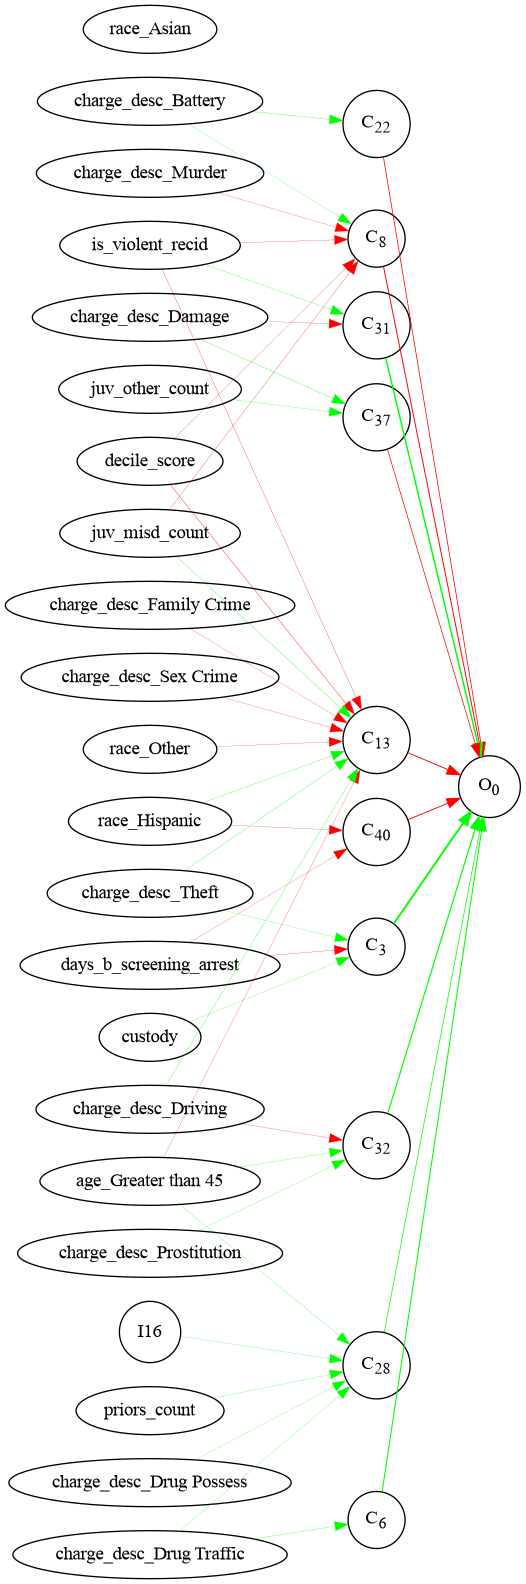

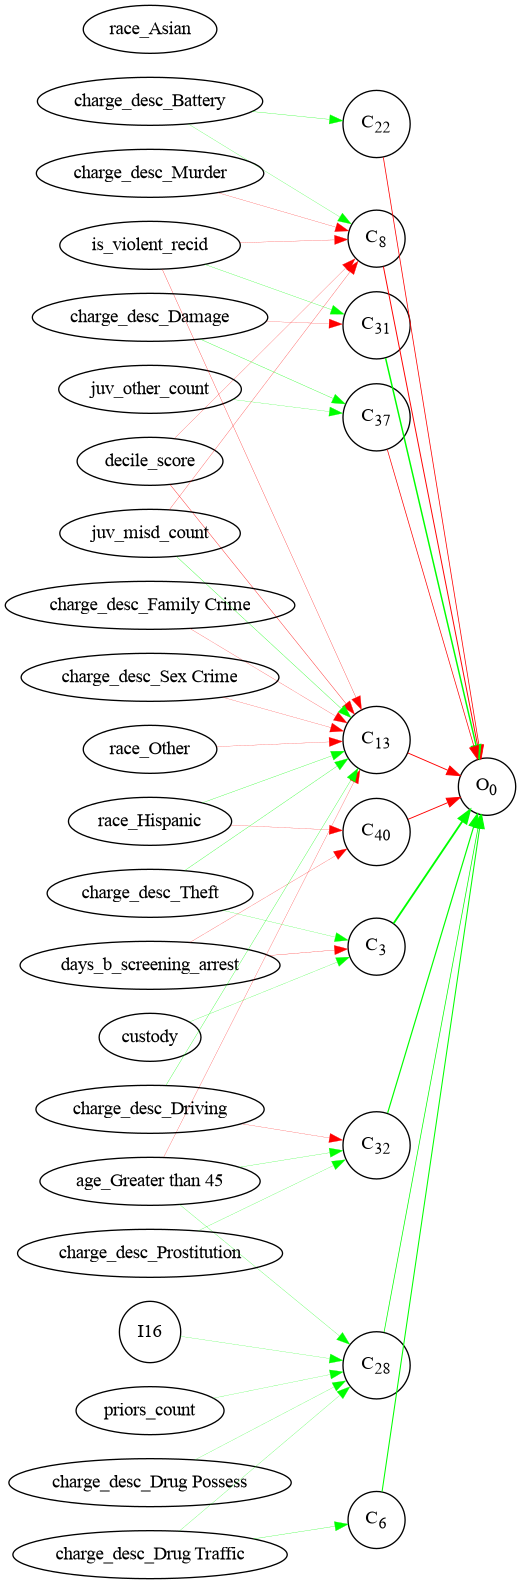

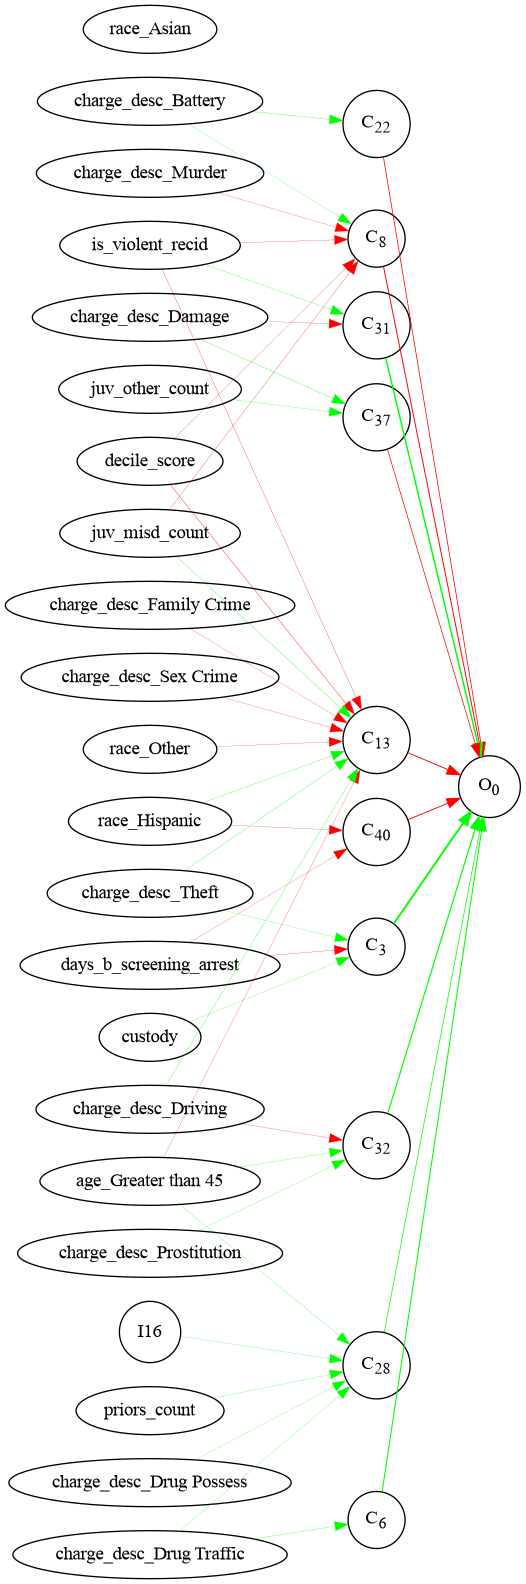

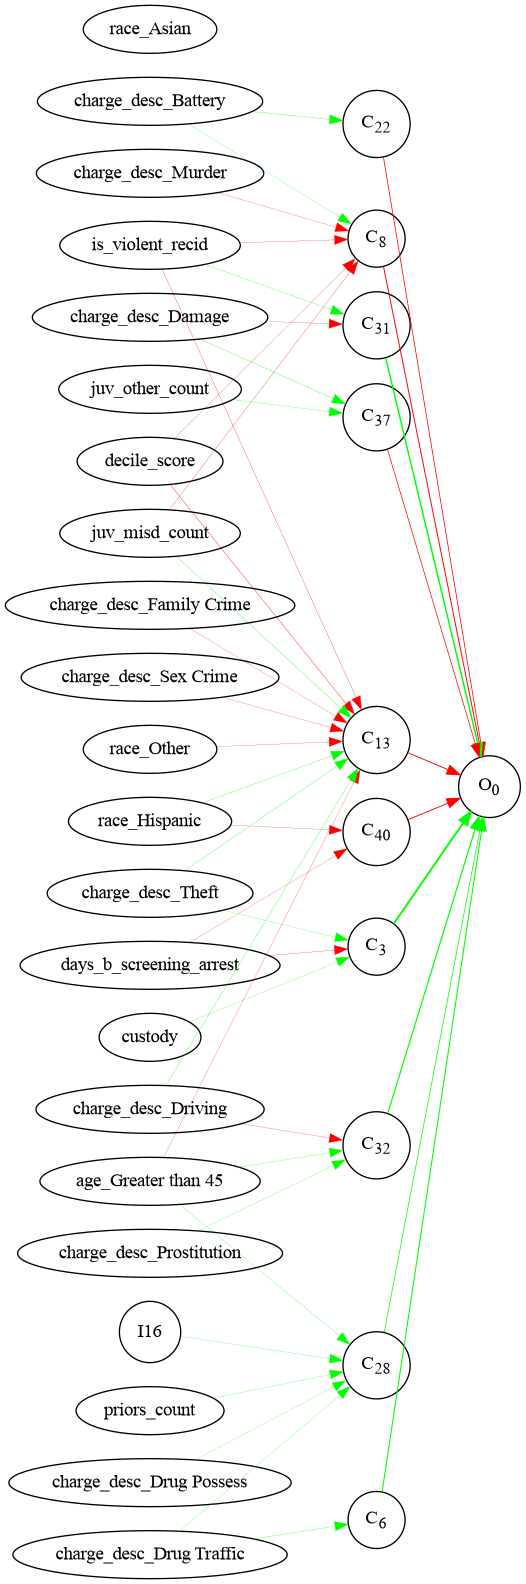

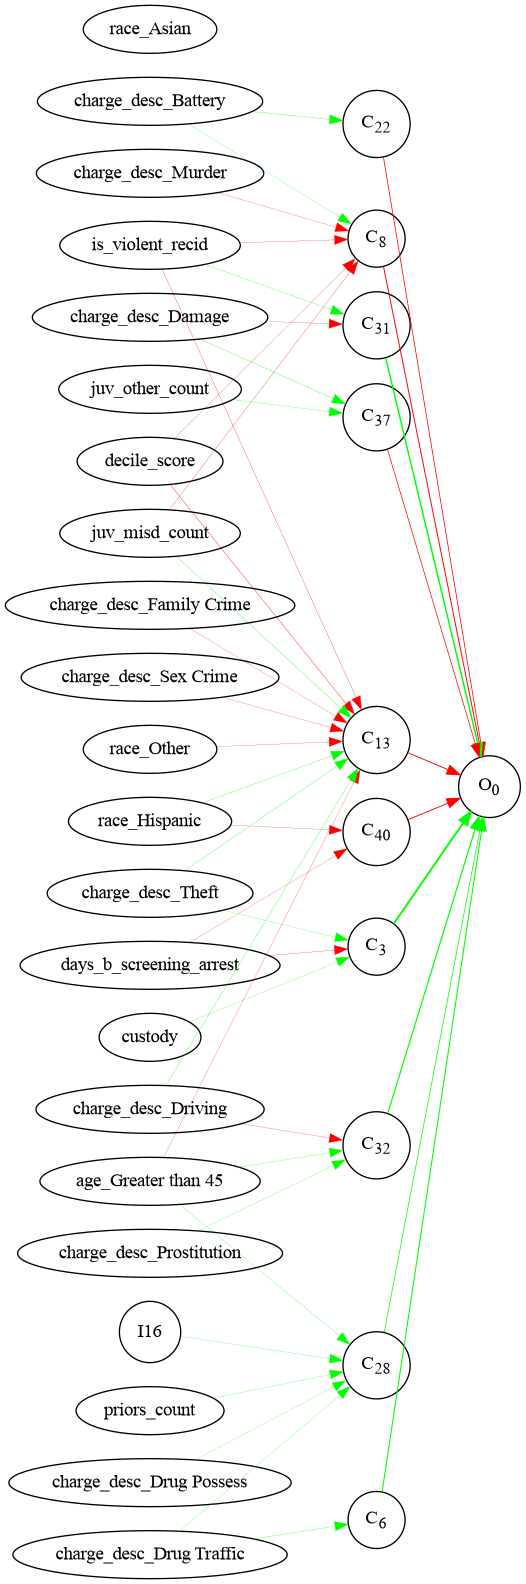

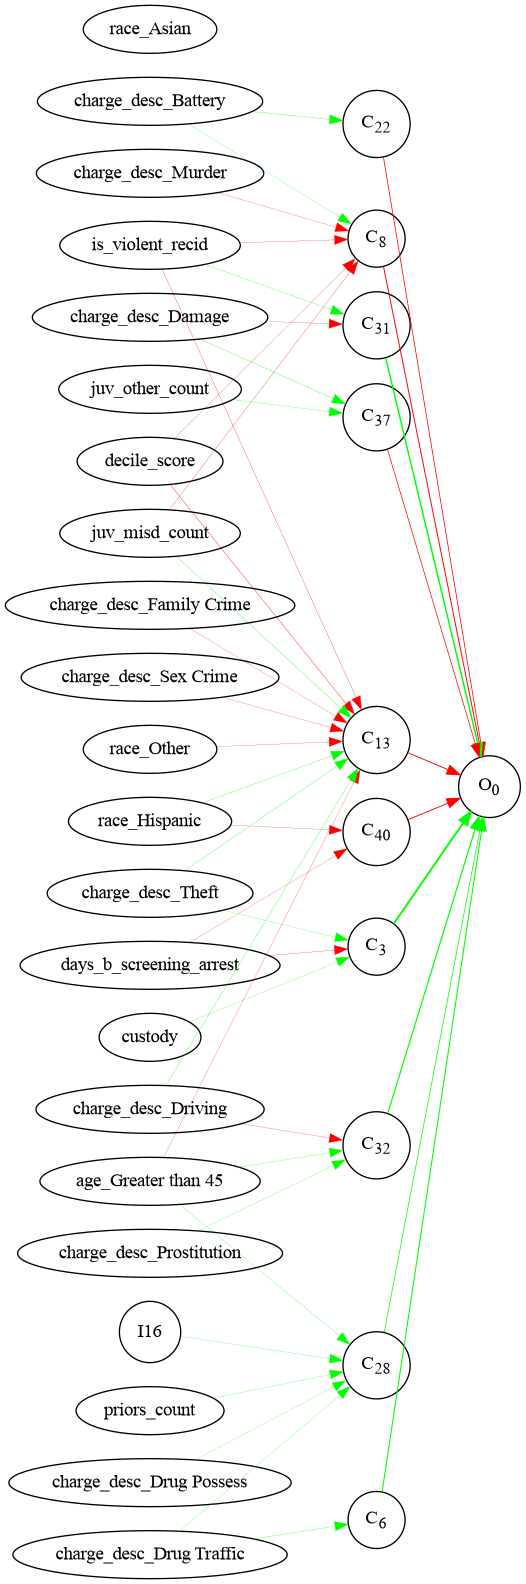

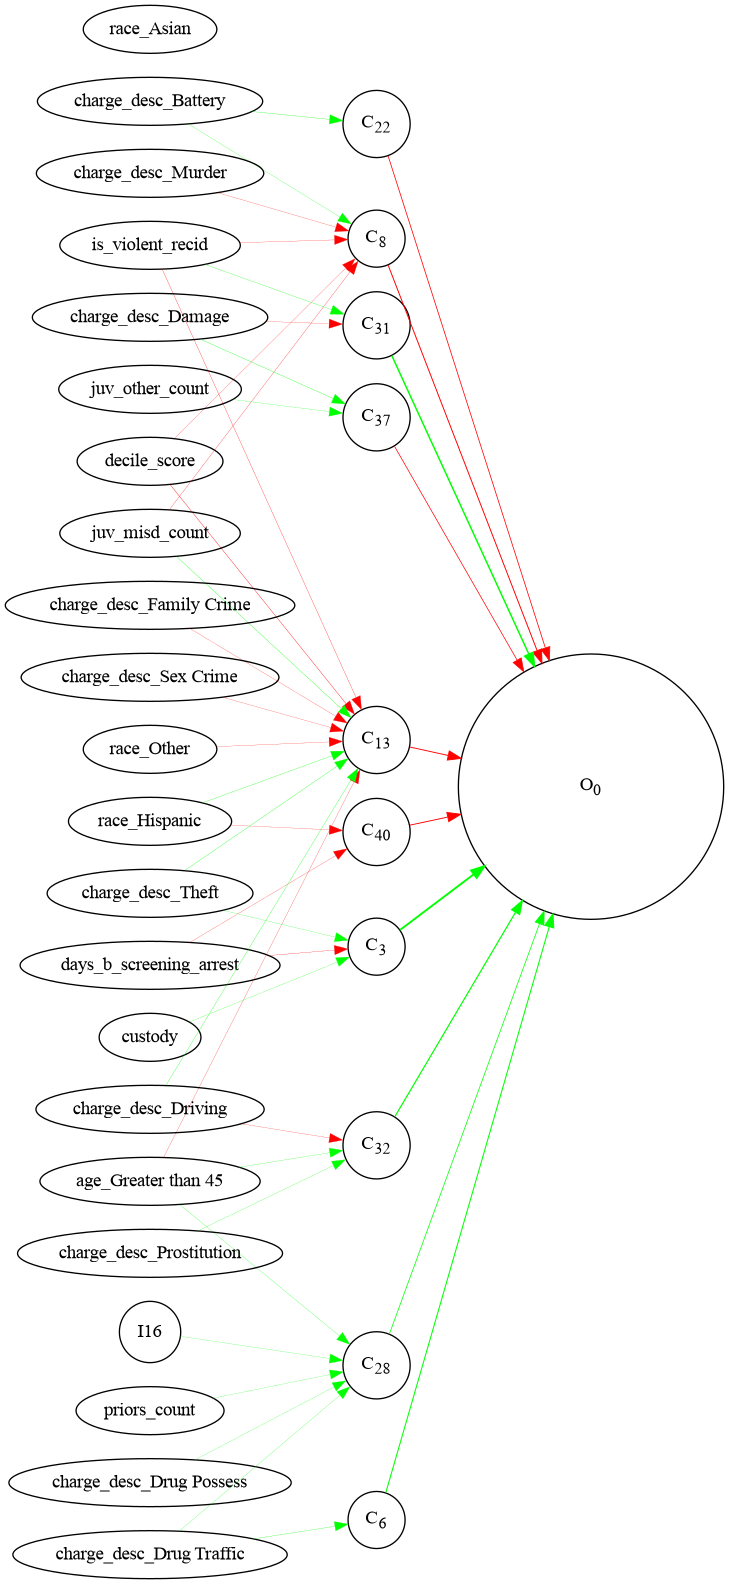

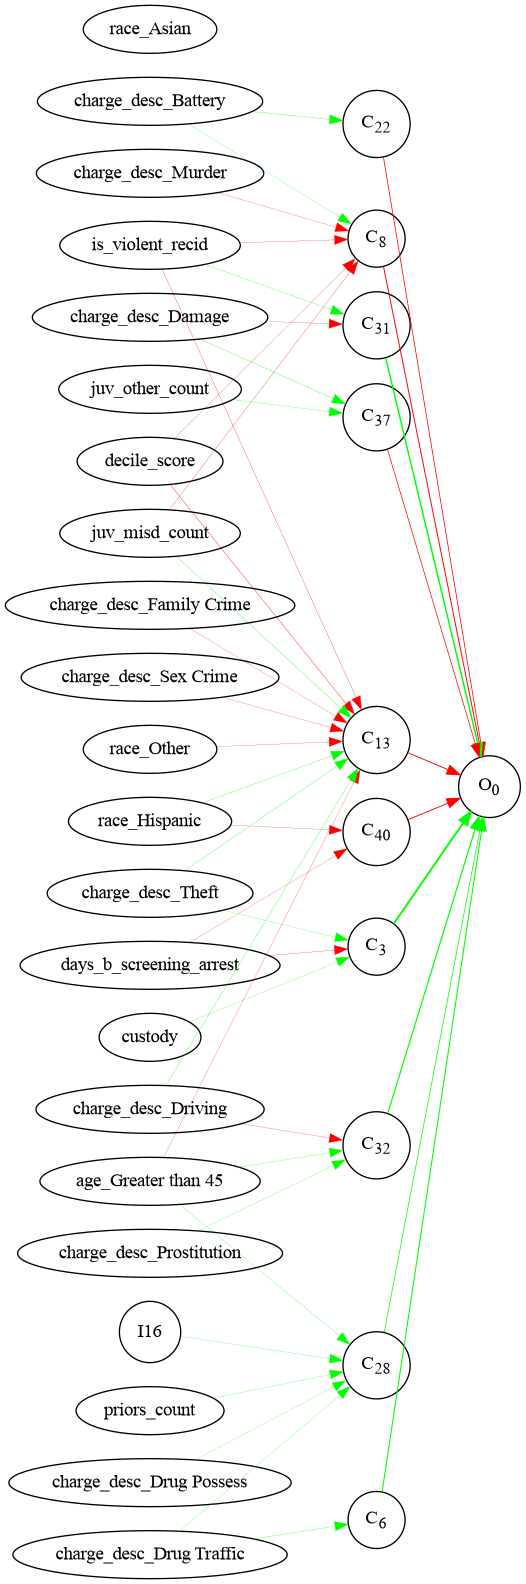

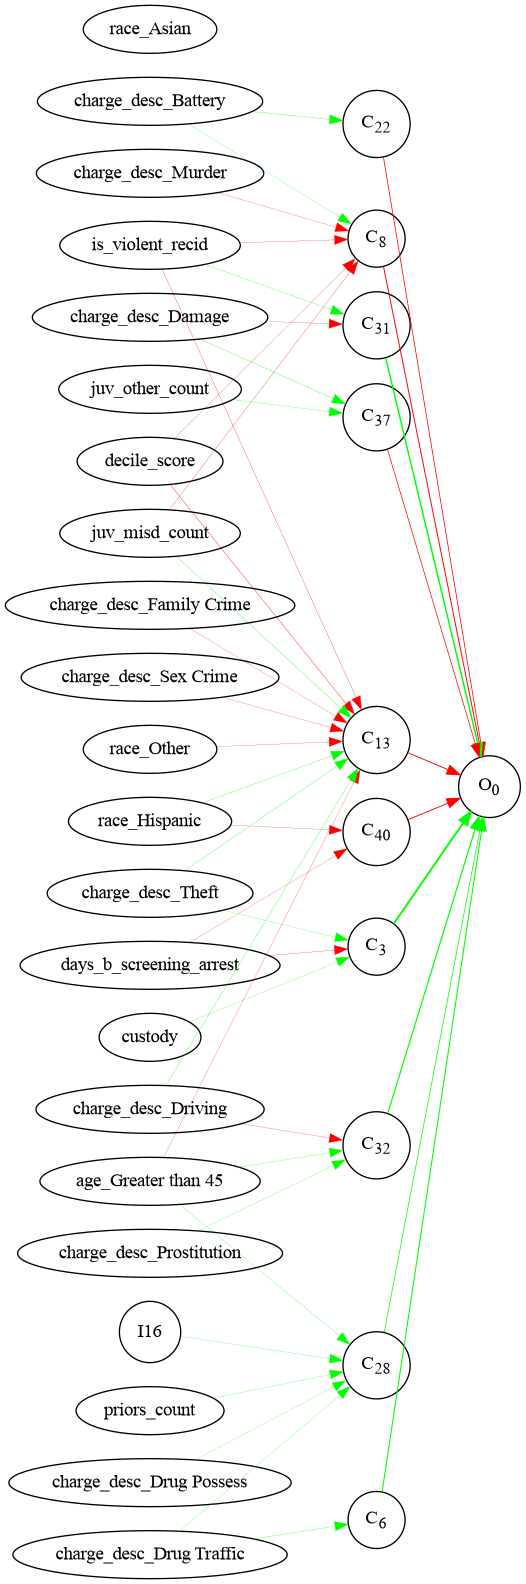

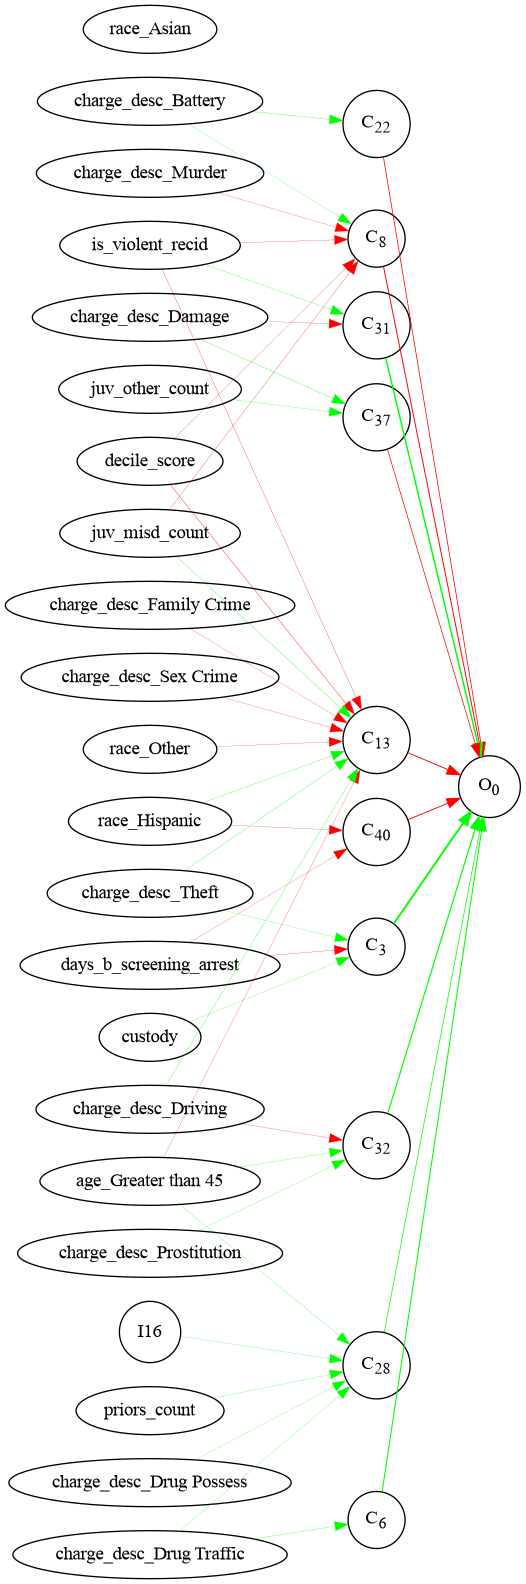

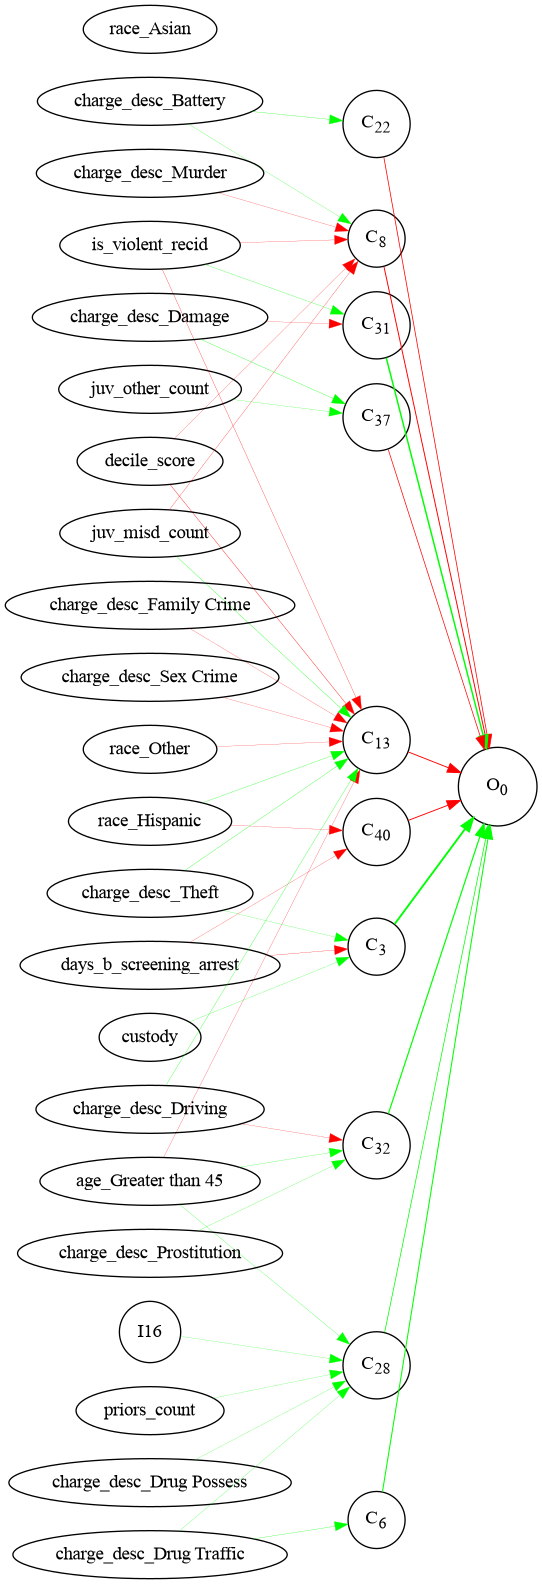

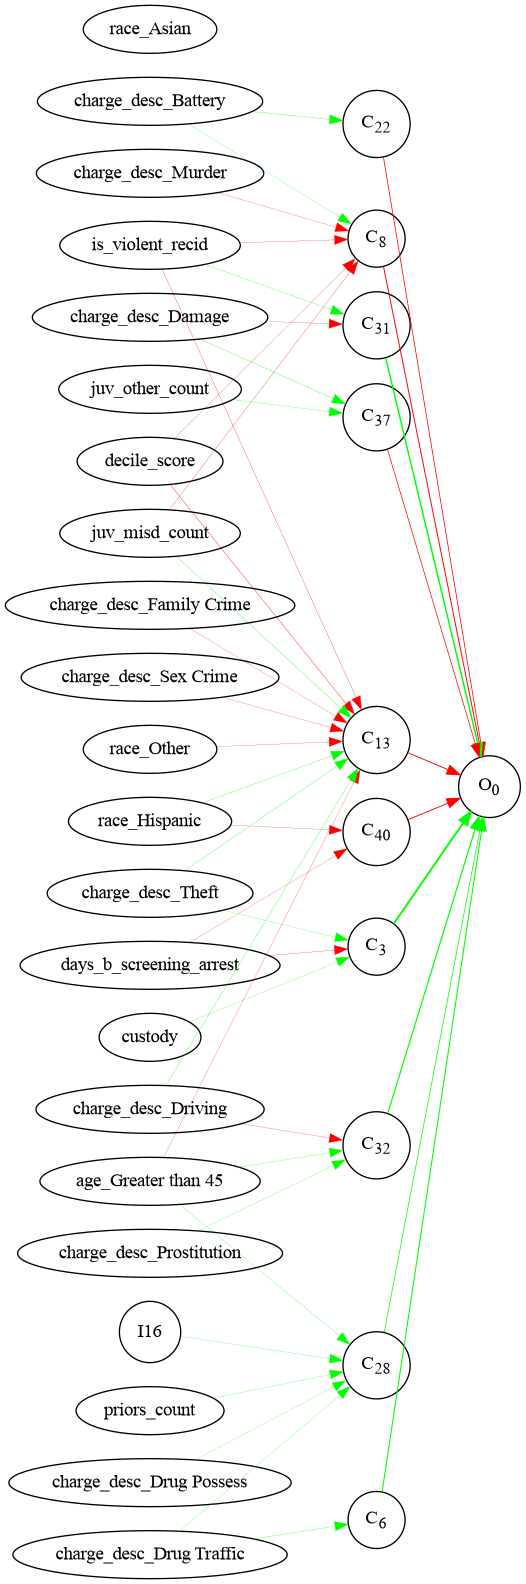

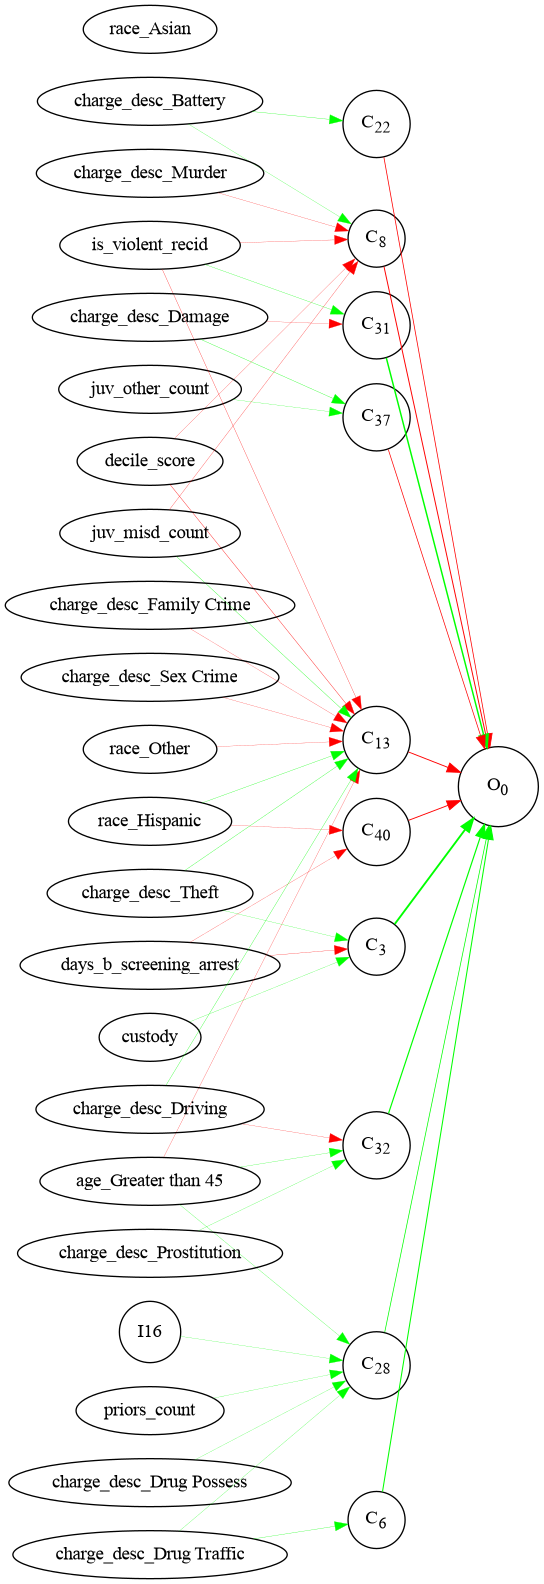

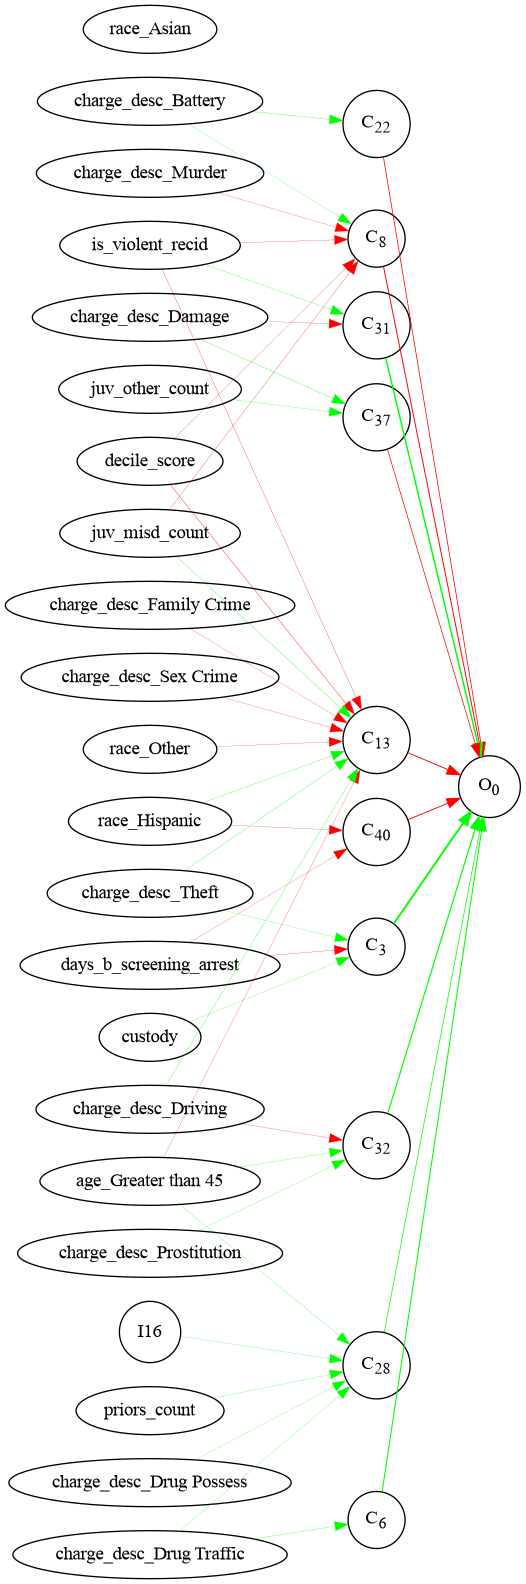

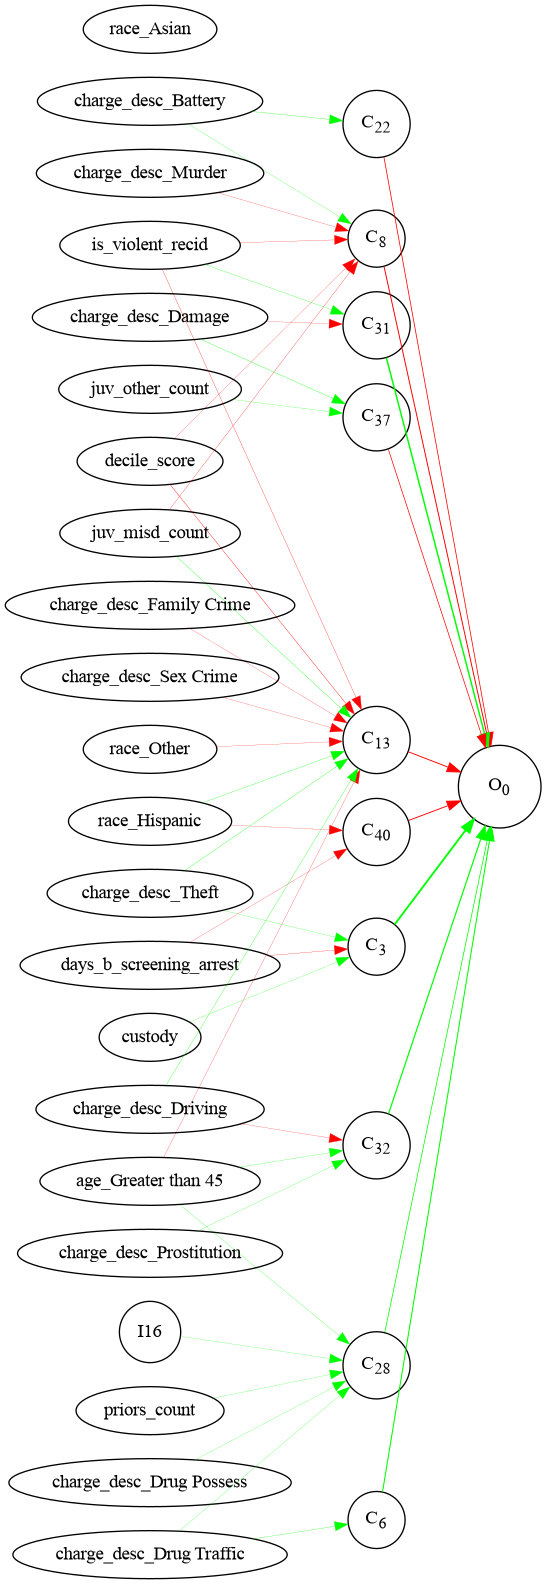

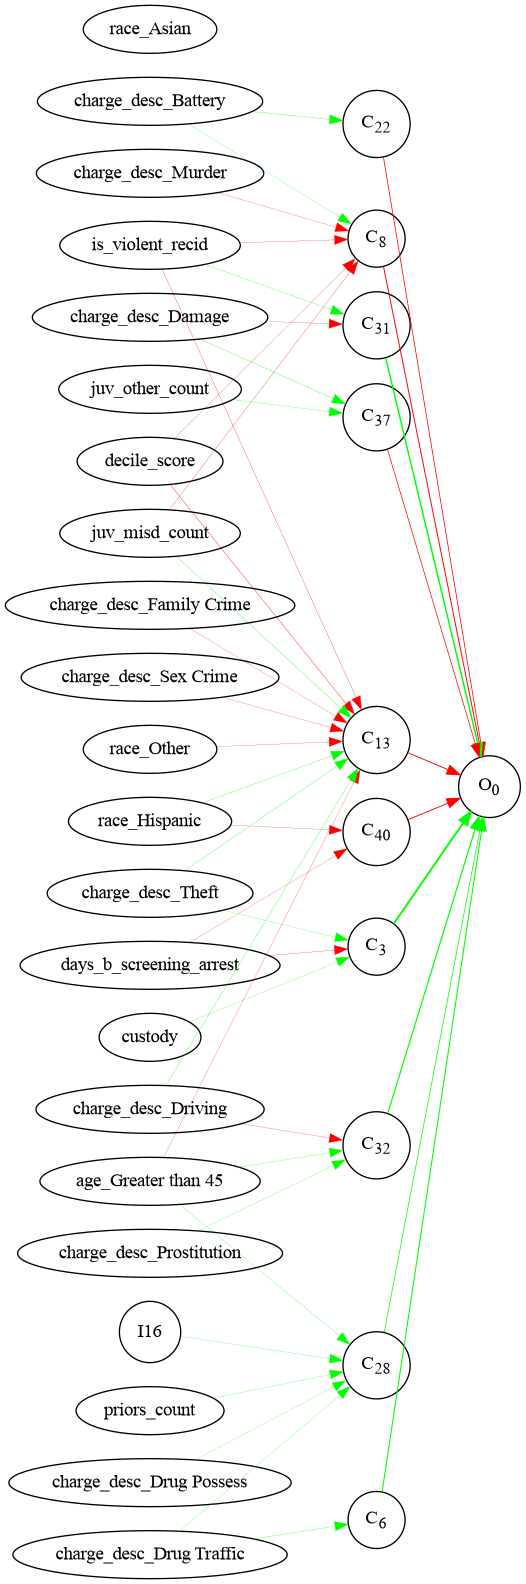

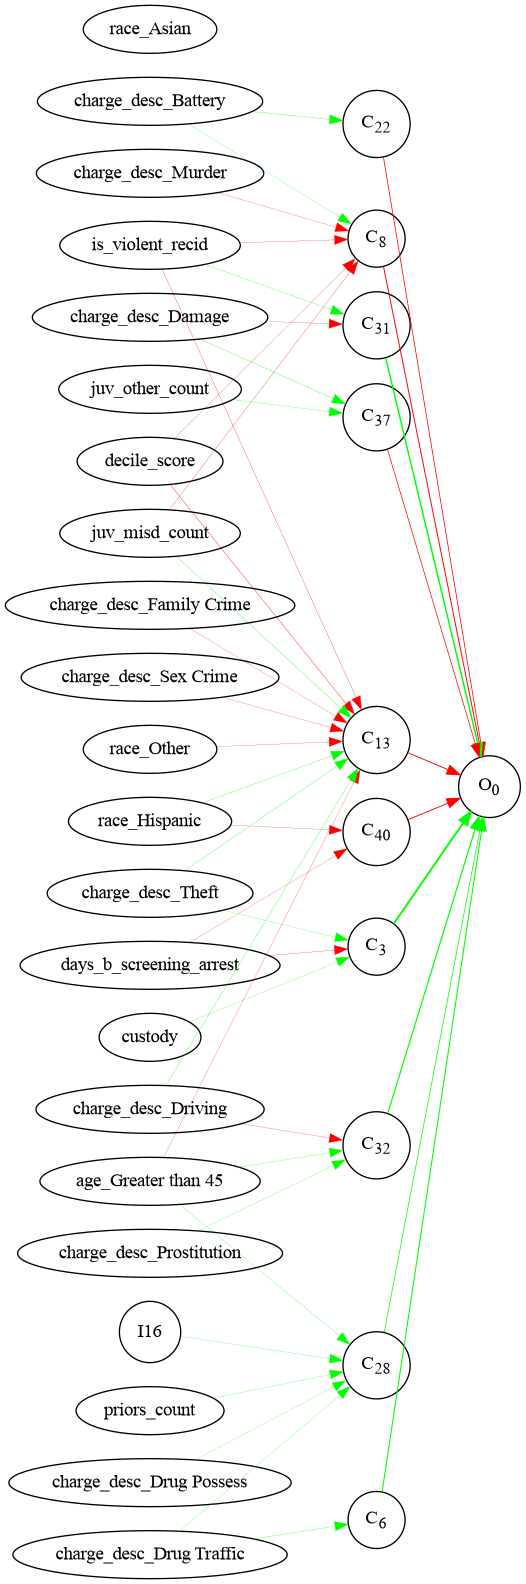

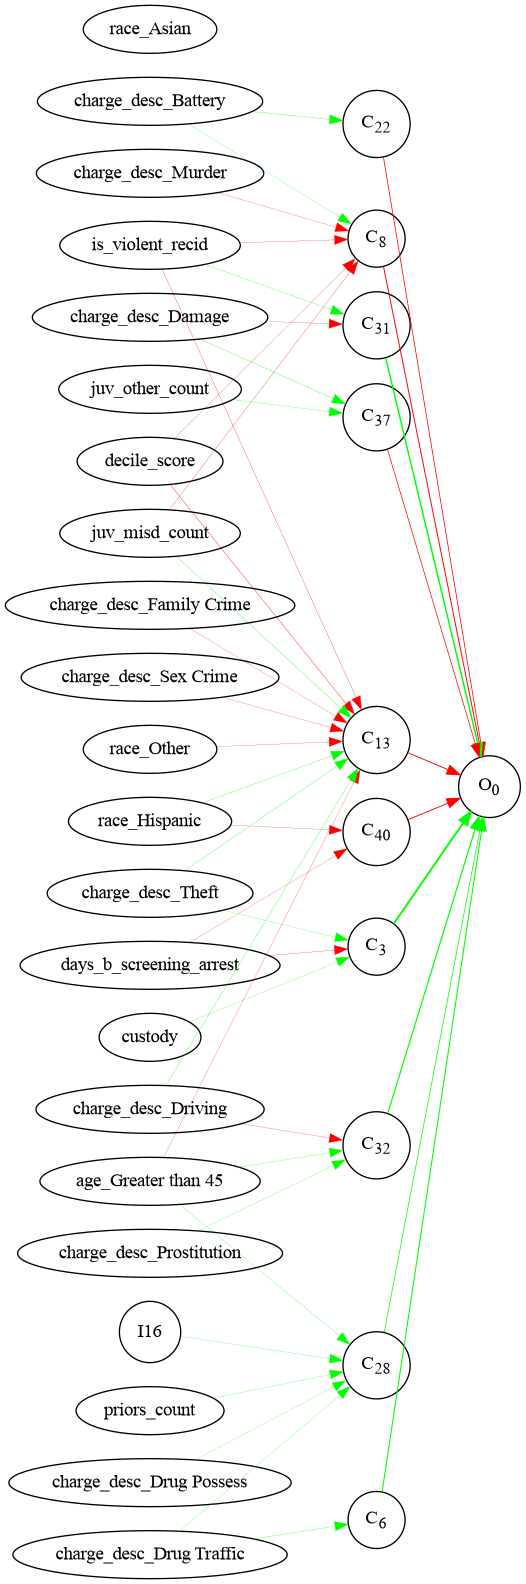

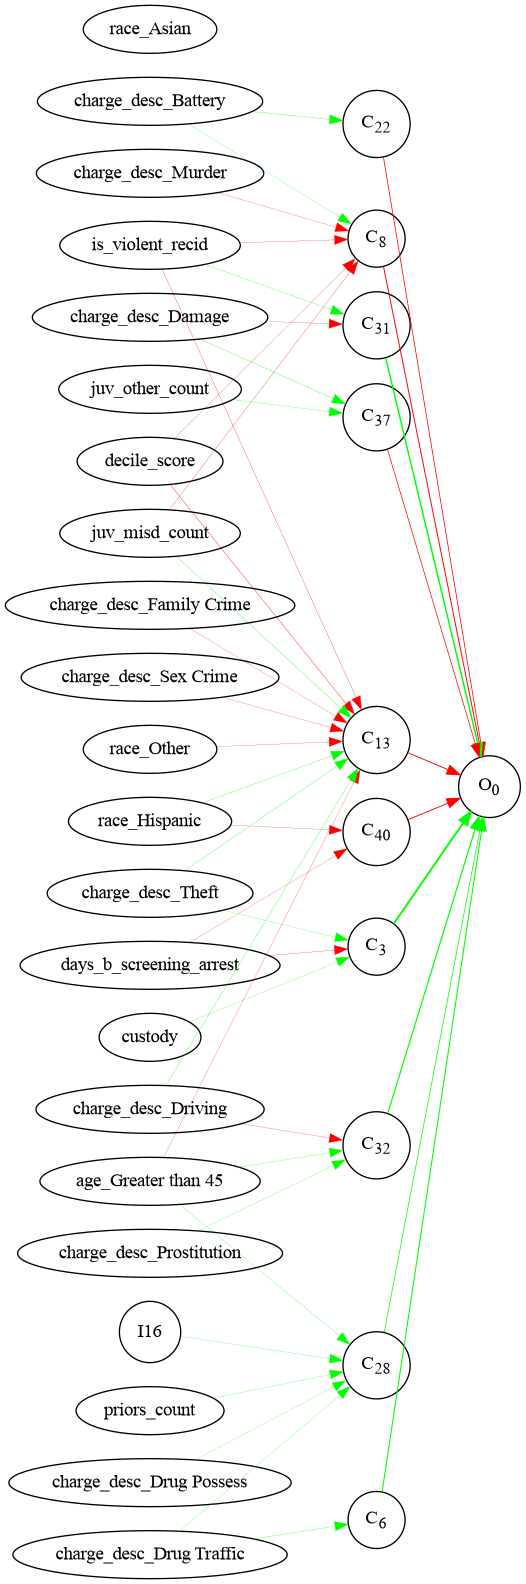

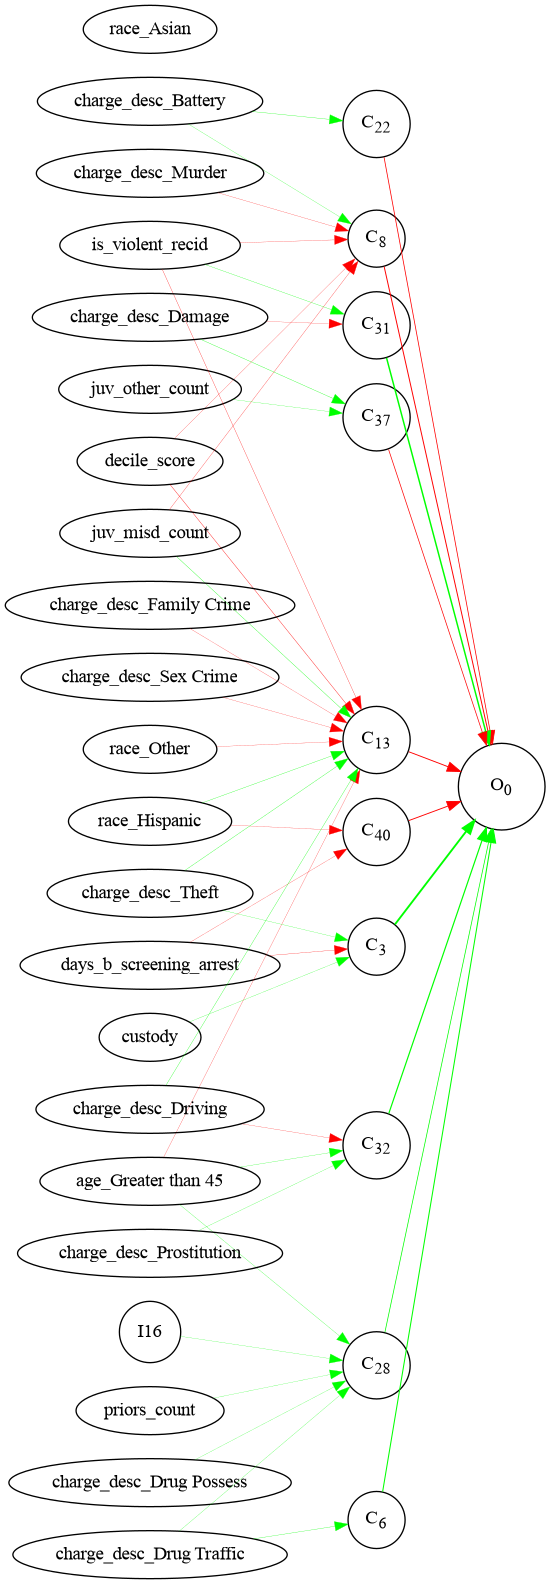

In [26]:
from IPython.display import Image, display

for test_index in range(0, 20):
  input = X_test[test_index].reshape(1,-1)
  output = np.array(y_test)[test_index]
  feature_names = X.columns.values
  number_of_hidden_nodes = [40]

  general_method_for_visualize_attack_and_supports_QBAF(input, output, merged_model.model, feature_names, number_of_hidden_nodes,
                                                        0.75, all_weights, all_biases, 'COMPAS_global', test_index)

  # Show example
  display(Image(filename=f'COMPAS_global/Graph_{test_index}.png'))

# Activation patching

We use activation patching to causally trace a pathway of important activations, which explain how a decision is made on MLPs.

Activation patching works by storing the activations on a clean run and a corrupted run, then substituting clean activations into the corrupted run to identify sufficient activations to recover the clean behaviour.

In [ ]:
from tf_keras.models import Model
from tf_keras import Input
from tf_keras.layers import Lambda

def patch_neuron_activations(model, layer_index, neuron_index, original_input):
    """
    Patches a specific neuron's activations in a layer.

    Args:
        model: The Keras model.
        layer_index: Index of the layer to patch.
        neuron_index: Index of the neuron to patch.
        original_input: The original input to the model.

    Returns:
        The output of the model with patched neuron activations.
    """
    # Get the activations for the original and patched inputs
    layer_output = model.layers[layer_index].output
    # Outputs the activations of the desired layer
    intermediate_model = Model(inputs=model.input, outputs=layer_output)

    original_activations = intermediate_model(original_input)

    # Replace only the specified neuron's activations - set to zero (ablate)
    patched_activations = original_activations.numpy()
    patched_activations[0, neuron_index] = 0
    patched_activations = tf.convert_to_tensor(patched_activations)

    # Create a new model that patches the activations
    inputs = Input(shape=original_input.shape[1:])
    x = inputs

    for i, layer in enumerate(model.layers):
        if i == layer_index:
            # Replace the activations with the patched ones
            x = Lambda(lambda x: patched_activations)(x)
        else:
            x = layer(x)

    patched_model = Model(inputs=inputs, outputs=x)

    # Run the patched model
    return patched_model(original_input)

In [ ]:
# Select sample from dataset
input_sample = X_test[0].reshape(1,-1)
orig_output = model(input_sample)[0].numpy()
print(orig_output)

layer_logit_diffs = []

# Loop over layers and neurons to identify critical ones
for layer_index in range(len(model.layers) - 1):
    if isinstance(model.layers[layer_index], Dense):
        print(f"Patching layer {layer_index}")
        logit_diffs = []
        for neuron_index in range(model.layers[layer_index].units):
            patched_output = patch_neuron_activations(model, layer_index, neuron_index, input_sample)
            patched_output = patched_output[0].numpy()
            logit_diff = np.abs(orig_output - patched_output)
            print(f"Neuron {neuron_index}: {patched_output}, logit diff {logit_diff}")
            logit_diffs.extend(logit_diff)
        layer_logit_diffs.append(logit_diffs)

In [ ]:
layer_neurons_by_importance = np.argsort(layer_logit_diffs, axis=1)[::-1]
layer_neurons_by_importance

In [ ]:
# Get which cluster each of these important layer neurons belong to

for i in range(len(layer_neurons_by_importance)):
  ranked_cluster_labels = cluster_labels[i][layer_neurons_by_importance[i]]
  print(ranked_cluster_labels)

In [ ]:
# TODO: justify your expected results, ideally with more formalism